In [1]:
import sys
sys.path.append('../../../patronus/')
# print(sys.path)
from global_config import * # load REPO_HOME_DIR, DATASET_DIR

import torch
from tqdm import tqdm


from train.utils import load_patronus_unet_model
from models.diffusion import SimpleDiffusion
from train.dataloader import get_dataloader
from analysis.analysis_utils import get_samples_from_loader, vis_samples

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Manipulation using prototype activaton vector
Fig. 1 in the paper.
## 1 - Define the dataset and trained version that you would like to inspect on

In [2]:
ds = 'CelebA'
version_num = 4
print(f'Selecting dataset: {ds} version {version_num}')

Selecting dataset: CelebA version 4


## 2 – Load trained model, initialize diffusion schedule, load test set

In [1]:
# ---- Load the patronus model -----
print('*'*30 + 'Load model' + '*'*30)
model, patronus_config_set = load_patronus_unet_model(ds_name=ds, 
                                                    version_num=version_num,
                            )

 # ---- Load the diffusion schduler ----
sd = SimpleDiffusion(
        num_diffusion_timesteps = patronus_config_set['TrainingConfig']['TIMESTEPS'],
        img_shape               = patronus_config_set['TrainingConfig']['IMG_SHAPE'],
        device                  = patronus_config_set['BaseConfig']['DEVICE'],
)

# ---- Load the test set ----- 
# we use test set to avoid memorization from the training set
dataloader_test = get_dataloader(
        dataset_name=f'{ds}-test',
        batch_size=256,
        device='cpu',
        shuffle = True, # test set should not be shuffled
)

# ---- Get the plausible maximum prototype similarity score ----
for i, (b_image, extra_info) in enumerate(dataloader_test):
    pact = model.proactBlock(b_image.to(device))
    max_pact = torch.max(pact).detach().cpu()
    break
print(f'Maximum prototype similarity score: {max_pact}')

## Select one sample to play with

In [4]:
selected_sample_id = ['200877.jpg'] # <-- CelebA
selected_img = get_samples_from_loader(dataloader_test, selected_sample_id)


 83%|████████▎ | 65/78 [00:39<00:07,  1.63it/s]

Found selected samples: ['200877.jpg']


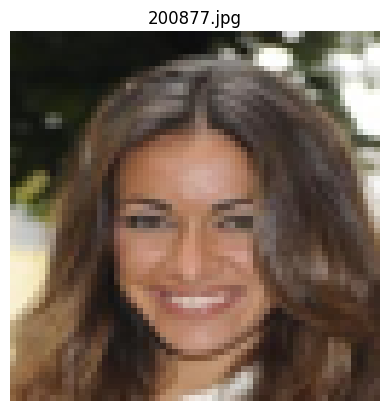

In [5]:
vis_samples(selected_img, selected_sample_id)

## Get prototype activation vector and x_T

In [6]:
selected_pact = model.proactBlock(selected_img.to(device))
selected_xT = sd.reverse_sample_loop(model,selected_img.to(device), model_kwargs={'given_cond_vector':selected_pact})['sample']

## 3 - Select prototype to manipulate on

In [7]:
def manipulate_img(selected_img,
                   selected_p_ind,
                   selected_pact,
                   selected_xT):
    enhanced_pact_chosen_p = selected_pact.clone()
    enhanced_pact_chosen_p[:,selected_p_ind] = max_pact.item()

    this_x_0_enhanced_all = sd.sample(model,
                                    shape=selected_img.shape ,
                                    noise=selected_xT,
                                    progress=True,
                                    model_kwargs={'given_cond_vector':enhanced_pact_chosen_p},
                                    num_samples=1)
    
    return this_x_0_enhanced_all


In [10]:
selected_p_ind = 38

# for each selected p, maximum it's possible value, and then generate the image
manipulated_img = manipulate_img(selected_img,
                                 selected_p_ind,
                                 selected_pact,
                                 selected_xT)

DEBUG:img.shape=torch.Size([1, 3, 64, 64])


  0%|          | 0/1000 [00:00<?, ?it/s]

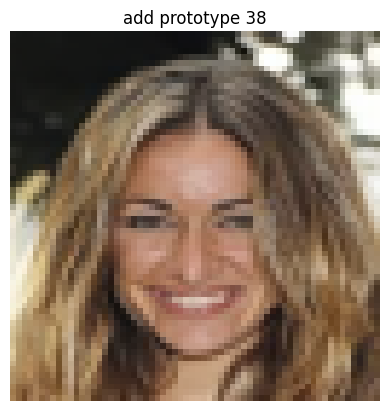

In [11]:
vis_samples(manipulated_img, [f'add prototype {selected_p_ind}'])